Phase 4 Project Submission

    Student Name: Tai Ngoc Bui
    Student Pace: Flex
    Scheduled Project Review: November 10th, 2024
    Instructor Name: Mark Barbour

### 1. Business Understanding

This project focuses on developing a robust recommendation system based on the MovieLens dataset to provide top 5 movie recommendations to a user, based on their ratings of other movie.  This dataset, from the GroupLens research lab at the University of Minnesota, contains tens of millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating), although the dataset used in this project only contains 100,000 of them.  

This model will use root mean squared error (RMSE) as the main metric to ensure the accuracy of our prediction. This is perhaps the most popular metric of evaluation for recommender system. RMSE is a metric which measure how much the signal and the noise is explained by the model. It penalises way less when close to actual prediction and way more when far from actual prediction compared to Mean Absolute Error metric, another popular metric of evaluation.

### 2. Data Understanding

This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided. The data are contained in the files links.csv, movies.csv, ratings.csv and tags.csv. 

The dataset files are written as comma-separated values files with a single header row. Columns that contain commas (,) are escaped using double-quotes ("). 

### 3. Exploratory Data Analysis

To begin with this project, I will import all necessary libraries and load datasets onto Dataframes including movies, ratings, links and tags.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
import random
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import knns, SVD
from surprise.similarities import cosine, msd, pearson
from surprise.model_selection import KFold
%matplotlib inline

In [2]:
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
links = pd.read_csv('data/links.csv')
tags = pd.read_csv('data/tags.csv')

#### a. Movies

In [3]:
print('Shape of this dataset:',movies.shape)
movies.info()
movies.head()

Shape of this dataset: (9742, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Each line of this movies.csv file after the header row represents one movie, and has the following format: movieId, title, genres. While movieId is stored under number format, title and genres are stored as string format.

Movie titles are entered manually or imported from https://www.themoviedb.org/, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

Genres are a pipe-separated list including Adventure, Animation, Children, Comedy, Fantasy,  
Romance, Drama, Action, Crime, Thriller, Horror, Mystery, Sci-Fi, War, Musical, Documentary, 
IMAX, Western, Film-Noir, (no genres listed).

The genres variable will surely be important while building the content-based recommendation engines since it describes the content of the film (i.e. Animation, Horror, Sci-Fi). A basic assumption is that films in the same genre should have similar contents. I'll attempt to see exactly which genres are the most popular.

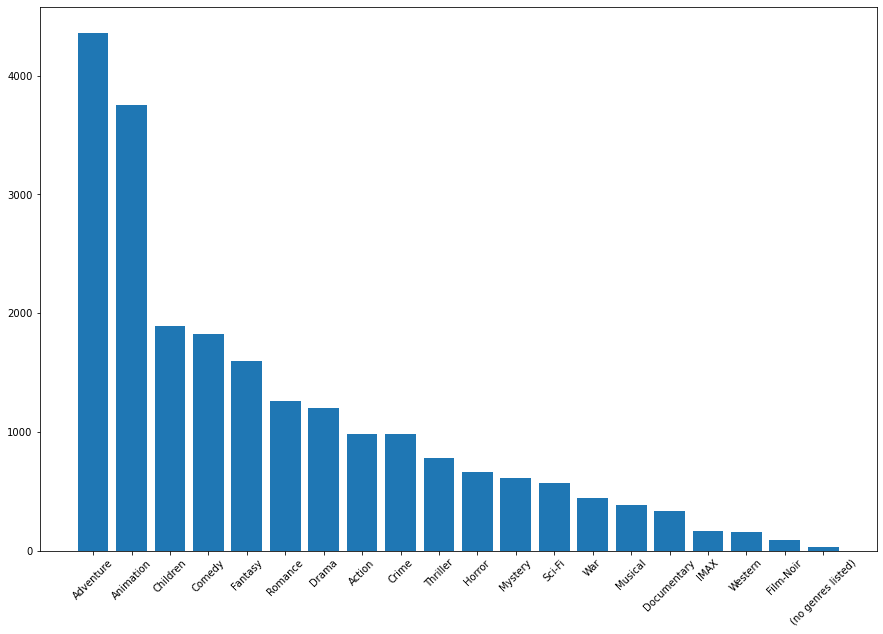

In [4]:
stacked = pd.DataFrame(movies.genres.str.split("|").tolist()).stack()
fig, ax = plt.subplots(figsize = (15,10))
plt.bar(stacked.unique(), stacked.value_counts())
plt.xticks(rotation = 45)
plt.show()

#### b. Ratings

All ratings are contained in the file ratings.csv. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:
userId, movieId, rating, timestamp.

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).
Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [5]:
#drop the timestamp column
ratings.drop('timestamp', axis = 1, inplace = True)
print('Shape of this dataset :',ratings.shape)
print('The number of unique users in Ratings:', len(ratings.userId.unique()))
print('The number of unique movies in Ratings:', len(ratings.movieId.unique()))
print(ratings.info())
ratings.head()

Shape of this dataset : (100836, 3)
The number of unique users in Ratings: 610
The number of unique movies in Ratings: 9724
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB
None


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


This confirms that there are 100836 ratings for different user and movie combinations with no null values.

The mean rating: 3.501556983616962


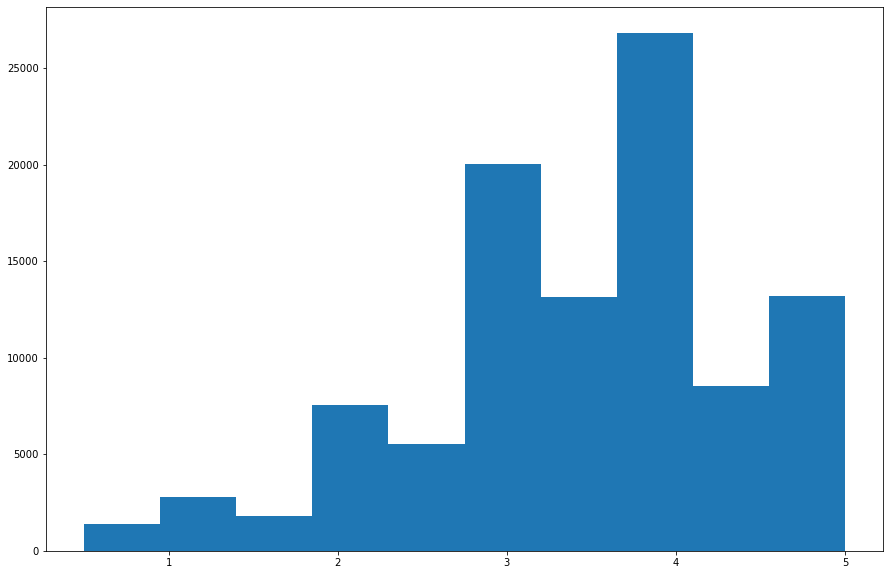

In [6]:
print(f"The mean rating: {ratings['rating'].mean()}")
fig, ax = plt.subplots(figsize = (15,10))

# Display distribution of rating
plt.hist(ratings['rating'])
plt.show();

It appears that users are quite generous in their ratings. The mean rating is 3.5 on a scale of 5. Half the movies have a rating of 4 and 5. I personally think that a 5-level rating skew wasn’t a good indicator as people could have different rating styles (i.e. person A could always use 4 for an average movie, whereas person B only gives 4 out for their favorites). Each user rated at least 20 movies, so I doubt the distribution could be caused just by chance variance in the quality of movies.

#### c. Links

Identifiers that can be used to link to other sources of movie data are contained in the file links.csv. Each line of this file after the header row represents one movie, and has the following format: movieId, imdbId, tmdbId

- movieId is an identifier for movies used by https://movielens.org. E.g., the movie Toy Story has the link https://movielens.org/movies/1.
- imdbId is an identifier for movies used by http://www.imdb.com. E.g., the movie Toy Story has the link http://www.imdb.com/title/tt0114709/.
- tmdbId is an identifier for movies used by https://www.themoviedb.org. E.g., the movie Toy Story has the link https://www.themoviedb.org/movie/862.


In [7]:
print('Shape of this dataset :',links.shape)
print(links.info())
links.head()

Shape of this dataset : (9742, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB
None


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


#### d. Tags

All tags are contained in the file tags.csv. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format: userId,movieId,tag,timestamp

Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.
Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.


In [8]:
print('Shape of this dataset :',tags.shape)
print(tags.info())
tags.head()

Shape of this dataset : (3683, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### 4. Preprocessing

As the only features here are the ratings of other users and items, we need to keep everything together. To load a dataset from a pandas dataframe, I need the Reader and Dataset packages. 

In [9]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

### 5. Collaborative Filtering Recommender

Two most ubiquitous types of personalized recommendation systems are Content-Based and Collaborative Filtering. The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that. In contrast, content-based recommendation systems focus on the attributes of the items and give you recommendations based on the similarity between them.

As the number of users are much smaller compared the number of movies in this particular project, I will use Collaborative Filtering as the main approach for this Recommender System. In general, collaborative filtering is the workhorse of recommender engines. It can be divided into Memory-Based Collaborative Filtering and Model-Based Collaborative filtering. 

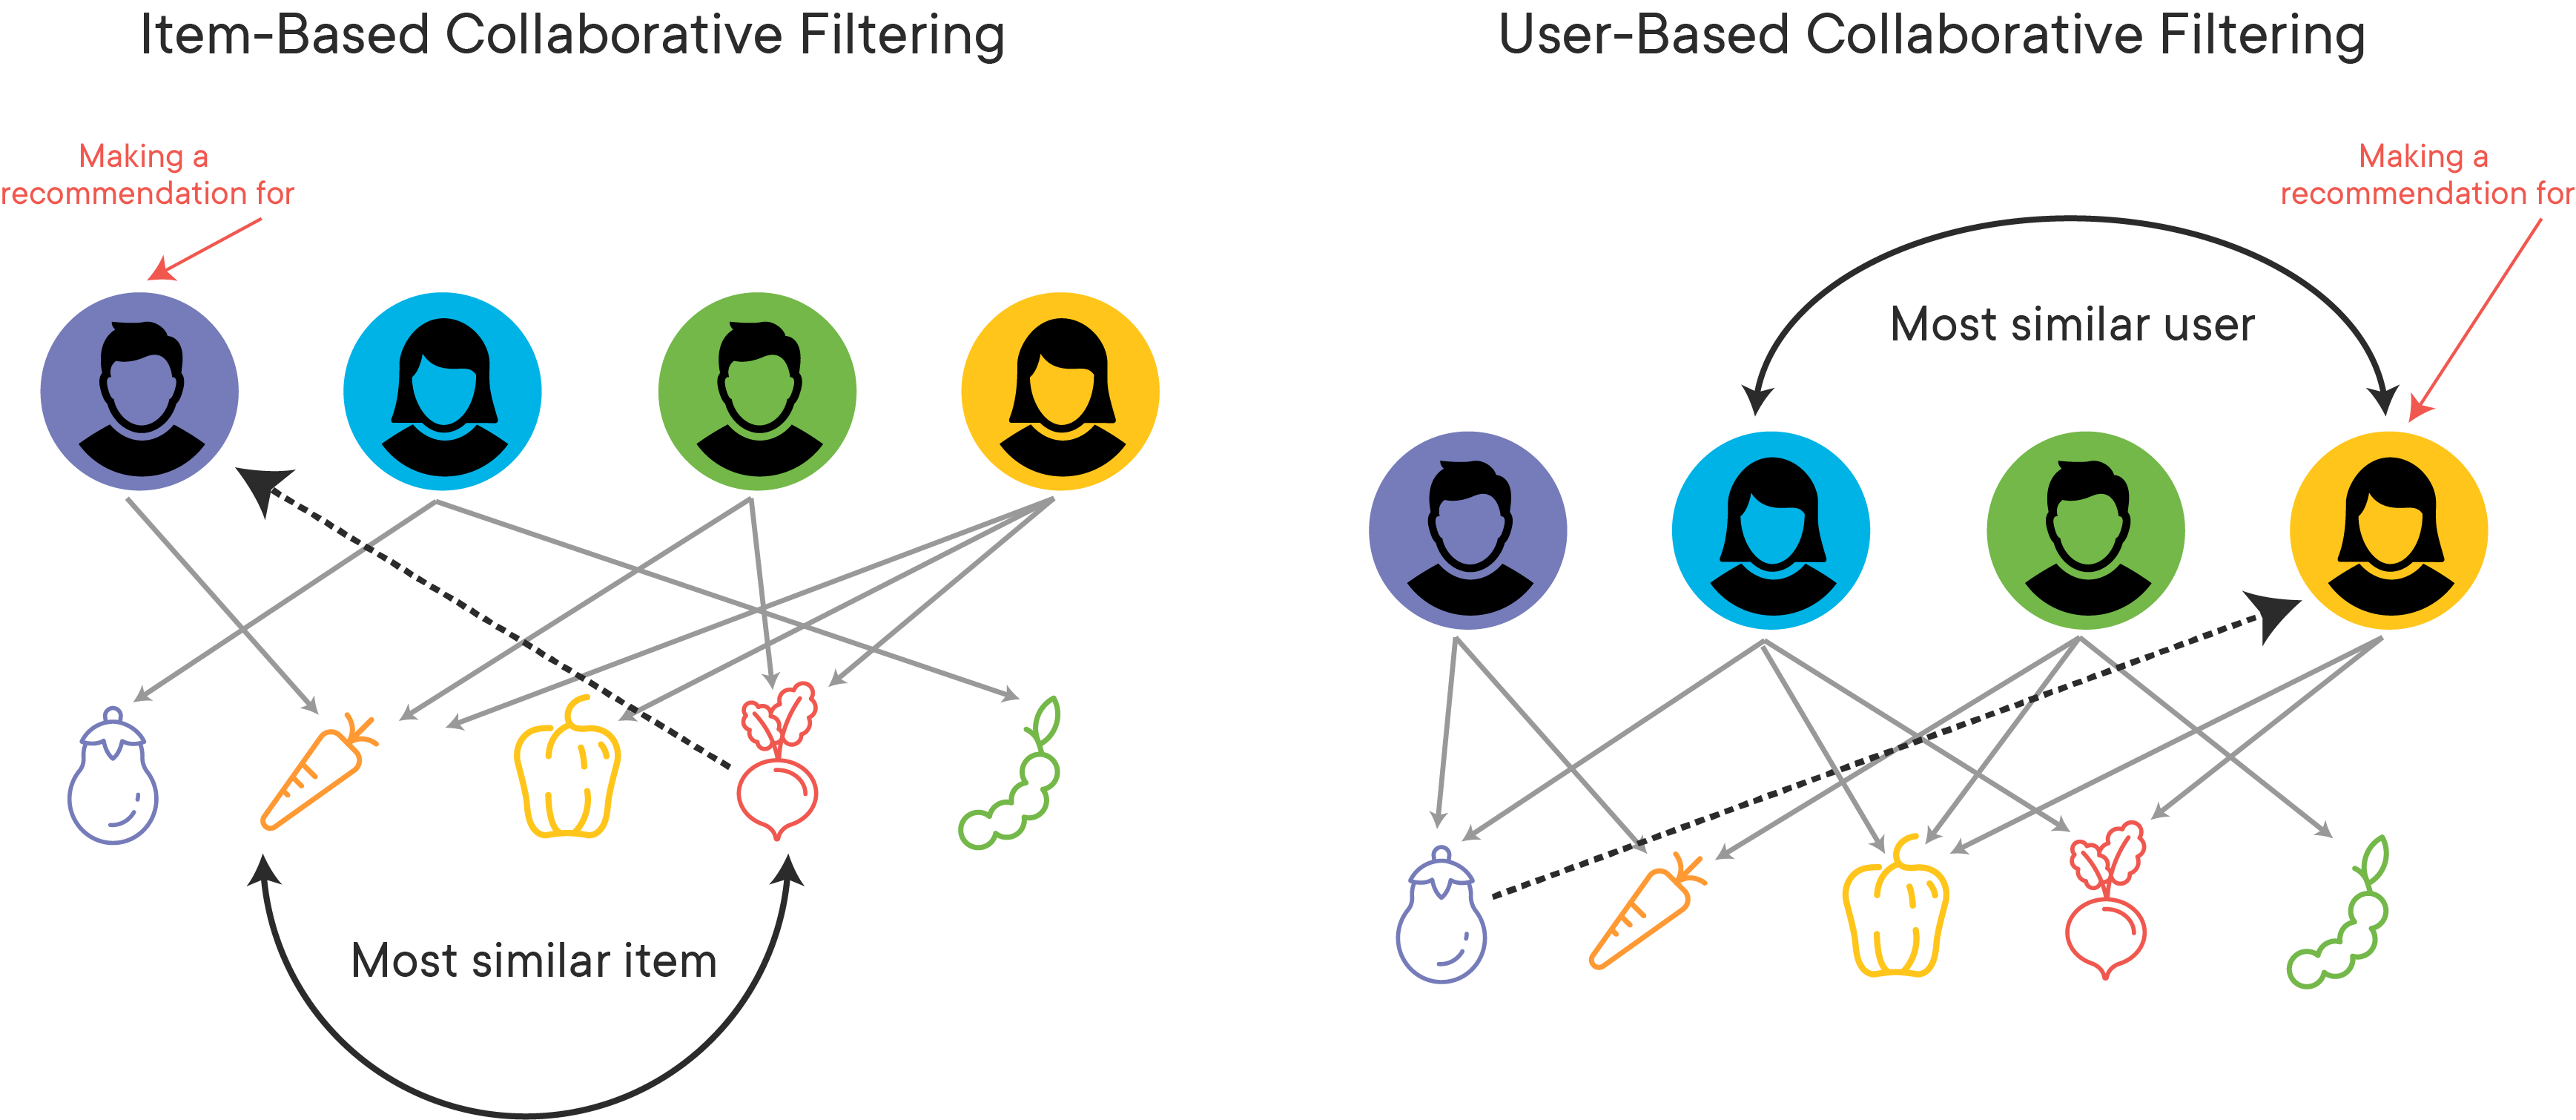

#### a. Base Model (Neighborhood-Based)

In [10]:
print("Number of users: ", len(ratings.userId.unique()), "\n")
print("Number of items: ", len(ratings.movieId.unique()), "\n")

Number of users:  610 

Number of items:  9724 



There are clearly way more items than users! We'll take that into account when inputting the specifications to our similarity metrics. Because we have fewer users than items, it will be more efficient to calculate user-user similarity rather than item-item similarity.

To begin with, we can calculate the more simple neighborhood-based approaches. Some things to keep in mind are what type of similarities you should use. These can all have fairly substantial effects on the overall performance of the model. With this first base model, I will start with user-based cosine similarity. The cosine similarity ranges from to -1 to 1. 1 means the two samples are the most similar and -1 means the two samples are the least similar.

Here I also use K-fold cross-validation with 5 as number of splits, which similar to a train test split with 80-20 proportion. 

In [11]:
# define a cross-validation iterator
kf = KFold(n_splits=5)

sim_cos = {"name": "cosine", "user_based": True}
basic = knns.KNNBasic(sim_options=sim_cos)

# define a list to hold rmse of each fold
results = []

for trainset, testset in kf.split(data):

    # train and test algorithm.
    basic.fit(trainset)
    predictions = basic.test(testset)

    # Compute and print Root Mean Squared Error
    results.append(accuracy.rmse(predictions, verbose=True))
print(sum(results)/len(results))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9715
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9792
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9735
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9752
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9662
0.9731238543394894


Besides cosine similarity, I also use user-based pearson as the similarity function for the base model to see if it can improve the base model performance.

In [12]:
sim_pearson = {"name": "pearson", "user_based": True}
# define a cross-validation iterator
kf = KFold(n_splits=5)

sim_cos = {"name": "cosine", "user_based": True}
basic = knns.KNNBasic(sim_options=sim_pearson)

# define a list to hold rmse of each fold
results = []

for trainset, testset in kf.split(data):

    # train and test algorithm.
    basic.fit(trainset)
    predictions = basic.test(testset)

    # Compute and print Root Mean Squared Error
    results.append(accuracy.rmse(predictions, verbose=True))
print(sum(results)/len(results))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9690
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9830
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9781
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9686
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9649
0.972738266647659


Both model had RMSE of about 0.97, meaning that it was off by almost 1 point for each guess it made for ratings. 

Cosine similarity and Pearson similarity are both metrics for measuring similarity but differ in focus and application. Cosine similarity measures the cosine of the angle between two vectors, focusing on their direction while ignoring magnitude, making it ideal for comparing high-dimensional or sparse data where the scale is irrelevant. In contrast, Pearson similarity evaluates the linear correlation between two vectors, accounting for their mean and relative deviations, making it suitable for analyzing relationships or trends in the data. While cosine similarity emphasizes vector orientation, Pearson similarity captures how well one variable's variations predict another’s, regardless of scaling or translation.

To further improve the neighborhood-based model, I will apply the KNNBaseline method, adding in bias term to reduce overfitting. KNNBasic directly computes similarity between users or items based on raw ratings, making it simple and intuitive but less effective in datasets with systematic biases, such as users who consistently rate items higher or lower than average. On the other hand, KNNBaseline accounts for these biases by incorporating baseline estimates for ratings, which adjust for global, user-specific, and item-specific biases. 

I will start using KNNBaseline with cosine similarity, then pearson right after. Base on what we have seen previously under KNNBasic model, there should be not much difference between the 2 similarity functions.

In [16]:
sim_pearson = {"name": "cosine", "user_based": True}
# define a cross-validation iterator
kf = KFold(n_splits=5)

knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)

# define a list to hold rmse of each fold
results = []

for trainset, testset in kf.split(data):

    # train and test algorithm.
    knn_baseline.fit(trainset)
    predictions = knn_baseline.test(testset)

    # Compute and print Root Mean Squared Error
    results.append(accuracy.rmse(predictions, verbose=True))
print(sum(results)/len(results))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8854
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8765
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8770
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8814
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8710
0.8782417029330881


In [13]:
sim_pearson = {"name": "pearson", "user_based": True}
# define a cross-validation iterator
kf = KFold(n_splits=5)

knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)

# define a list to hold rmse of each fold
results = []

for trainset, testset in kf.split(data):

    # train and test algorithm.
    knn_baseline.fit(trainset)
    predictions = knn_baseline.test(testset)

    # Compute and print Root Mean Squared Error
    results.append(accuracy.rmse(predictions, verbose=True))
print(sum(results)/len(results))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8693
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8793
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8808
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8763
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8768
0.8765026657172887


By adding in bias term, KNNBaseline method achieved the best RMSE of 0.8765 with Pearson similarity. Here I will build a recommend function that takes in an user id and the list of predictions. Based on the predictions, it will suggest a list of movies that have highest predicted ratings to the user. 

In [14]:
def recommend(user_id, predictions, n=5):
    """Return the top-N recommendation for each user from a set of predictions.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    l = list()
    for i in top_n[user_id]:
        l.append(movies[movies['movieId'] == i[0]].title.values[0])
    return l

In [15]:
# Print the 5 recommended items for user with id using k near neighbors
rec = recommend(75, predictions)
rec

['Witness for the Prosecution (1957)',
 '2001: A Space Odyssey (1968)',
 'Mystic River (2003)',
 'Transporter 2 (2005)',
 'Star Trek IV: The Voyage Home (1986)']

Overall, Memory-based Collaborative Filtering is easy to implement and produce reasonable prediction quality. However, there are some drawback of this approach:

- It doesn't address the well-known cold-start problem, that is when new user or new item enters the system.
- It can't deal with sparse data, meaning it's hard to find users that have rated the same items.
- It suffers when new users or items that don't have any ratings enter the system.
- It tends to recommend popular items.


#### b Model-Based Methods (Matrix Factorization)

Besides memory-based methods, model-based method is another popular approach of Collaborative Filtering. Unlike memory-based collaborative filtering, which directly calculates similarity scores between users or items (such as user-based or item-based nearest-neighbor algorithms), model-based approaches use a data-driven model to generalize patterns in the data. Here's a breakdown of how it works

In model-based collaborative filtering, a model is trained to learn hidden (latent) factors that represent users and items. These factors capture preferences in a reduced feature space. Techniques like matrix factorization (e.g., Singular Value Decomposition (SVD), Non-negative Matrix Factorization (NMF)) are popular for learning these latent factors, effectively representing users and items as vectors in this space.

Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF. The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and 

In [17]:
raw_ratings = data.raw_ratings

# shuffle ratings if you want
random.shuffle(raw_ratings)

# A = 90% of the data, B = 10% of the data
threshold = int(0.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

data.raw_ratings = A_raw_ratings  # data is now the set A

param_grid = {
    'lr_all': [0.005, 0.002, 0.001, 0.0005],
    'n_factors': [20, 50, 75, 125, 150, 250],
    'reg_all': [0.005, 0.01, 0.015, 0.02, 0.03, 0.05],
    'n_epochs': [10, 20, 30, 50, 70, 100]
}
gs_model = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1,joblib_verbose=5, cv = 5)
gs_model.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed: 32.0min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 36.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 45.7min
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed: 62.7min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 69.7min
[Parallel(n_jobs=-1)]: Done 3018 tasks      | elapsed: 83.5min
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed: 98.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 112.8min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 |

In [22]:
print(f"Best parameters: {gs_model.best_params['rmse']}")
algo = gs_model.best_estimator["rmse"]
# retrain on the whole set A
trainset = data.build_full_trainset()
algo.fit(trainset)

# Compute biased accuracy on A
predictions_SVD_A = algo.test(trainset.build_testset())
print("Biased accuracy on A,", end="   ")
accuracy.rmse(predictions_SVD_A, verbose = 'True')

# Compute unbiased accuracy on B
testset = data.construct_testset(B_raw_ratings)  # testset is now the set B
predictions_SVD_B = algo.test(testset)
print("Unbiased accuracy on B,", end=" ")
accuracy.rmse(predictions_SVD_B, verbose = 'True')

Best parameters: {'lr_all': 0.005, 'n_factors': 250, 'reg_all': 0.05, 'n_epochs': 100}
Biased accuracy on A,   RMSE: 0.3072
Unbiased accuracy on B, RMSE: 0.8519


0.8519389959797959

With this MovieLens dataset, SVD is the best model with the lowest test set root squared mean error of 0.8519. The parameters used for tuning SVD is as follows: 'lr_all': 0.005, 'n_factors': 250, 'reg_all': 0.05, 'n_epochs': 100

While model-based collaborative filtering excels in scalability and predictive power, its drawbacks include:
- challenges with new users/items (similar to memory-based model)
- high initial computational cost for the decomposition
- overfitting risks
- requires periodic retraining to incorporate new interactions

Here, I will make a recommendation for user with id = 58 based on SVD predictions.

In [23]:
# Print the 5 recommended items for user with id using SVD
rec = recommend(75, predictions_SVD_B)
rec

['Casablanca (1942)',
 'Star Trek II: The Wrath of Khan (1982)',
 'Hunt for Red October, The (1990)',
 'Sting, The (1973)',
 'Lawrence of Arabia (1962)']

Comparing with recommendations provided by KNNBaseline model, both suggest this user will probably like Star Trek despite different versions suggested in this case. On the other hand, this user with id 75 seems to prefer old style movies. While 3 out of 5 movies recommended by KNNBaseline were made before 1990, all movies recommended by SVD model were made in this time frame. 

### 6. Summary 

Based on our analysis and testing with different models, I want to recommend Model-based Singular Value Decomposition (SVD) with user-based focus as the final model for the recommendation system given the MovieLens dataset. The parameters used in this model is 'lr_all' = 0.005, 'n_factors' = 250, 'reg_all' = 0.05, and 'n_epochs' = 100. Based on our test results, this model can achieve 0.8519 root mean squared error. 

Another reason for using Model-based SVD is its scalability for large scale applications. This scalability ensures that SVD-based systems can handle millions of users and items effectively. Moreover, SVD can uncover latent relationships between users and items, such as implicit preferences or themes, which are not immediately visible in the raw interaction matrix. These latent features improve the system's ability to predict user preferences, even for items that the user has not explicitly interacted with.

### 7. Future Works

To better improve the quality of this report, I will extend this project by investigate deep learning-based methods like Neural Collaborative Filtering (NCF) or autoencoders for better capture of complex user-item interactions. Another possibility to improve this project is to combine collaborative filtering with content-based filtering or context-aware techniques to address limitations like cold-start problems.